# 전체 학습 과정 

In [1]:
import torch.nn as nn 
import torch 
import torchvision 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from glob import glob 
import pandas as pd 
from PIL import Image
from tqdm import tqdm 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,Dataset
import os 
import yaml 
import wandb  
import json
import argparse 

from src import Convolution_Auto_Encoder, Mnist_Dataset,MVtecADDataset,Datadir_init
from src import MVtecEncoder,MVtecDecoder,Convolution_Auto_Encoder
from src import Machine_Metric,Reconstruction_Metric
from src import create_transformation
from src.set_transformation import create_transformation



# Configuration 

# 데이터셋 로드 
- 이미지 디렉토리와 라벨 로드 

In [ ]:
class Datadir_init:
    def __init__(self,Dataset_dir='./Dataset/hazelnut'):
        self.Dataset_dir = Dataset_dir 
        
    def test_load(self):
        test_label_unique = pd.Series(sorted(glob(f'{self.Dataset_dir}/test/*'))).apply(lambda x : x.split('/')[-1]).values
        test_label_unique = {key:value for value,key in enumerate(test_label_unique)}
        self.test_label_unique = test_label_unique 

        test_dir = f'{self.Dataset_dir}/test/'
        label = list(test_label_unique.keys())[0]

        test_img_dirs = [] 
        test_img_labels = [] 
        for label in list(test_label_unique.keys()):
            img_dir = sorted(glob(test_dir +f'{label}/*'))
            img_label = np.full(len(img_dir),test_label_unique[label])
            test_img_dirs.extend(img_dir)
            test_img_labels.extend(img_label)
        return np.array(test_img_dirs),np.array(test_img_labels) 

    def train_load(self):
        train_img_dirs = sorted(glob(f'{self.Dataset_dir}/train/good/*.png'))
        return np.array(train_img_dirs) 

class MVtecADDataset(Dataset):
    def __init__(self,cfg,img_dirs,labels=None,Augmentation=None):
        super(MVtecADDataset,self).__init__()
        self.cfg = cfg 
        self.dirs = img_dirs 
        self.augmentation = self.__init_aug__(Augmentation)
        self.labels = self.__init_labels__(labels)

    def __len__(self):
        return len(self.dirs)

    def __init_labels__(self,labels):
        if np.sum(labels) !=None:
            return labels 
        else:
            return np.zeros(len(self.dirs))
    
    def __init_aug__(self,Augmentation):
        if Augmentation == None:
            augmentation = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Resize((self.cfg['img_size'],self.cfg['img_size']))
                                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                            ])
        else: 
            augmentation = Augmentation 
        return augmentation                                      

    def __getitem__(self,idx):
        img_dir = self.dirs[idx]
        img = Image.open(img_dir)
        img = self.augmentation(img)

        if np.sum(self.labels) !=None:
            return img,self.labels[idx] 
        else:
            return img



In [ ]:
Data_dir = Datadir_init()
train_dirs = Data_dir.train_load()
test_dirs,test_labels = Data_dir.test_load()

train_dset = MVtecADDataset(cfg,train_dirs[:indx],Augmentation=augmentation)

In [2]:
def parse_arguments():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-aug_number')
    parser.add_argument('-save_dir')
    args = parser.parse_args() 
    return args 

def preprocess(cfg,augmentation=None):
    #mk save dir 
    try:
        os.mkdir(f"./Save_models/{cfg['save_dir']}")
    except:
        pass
    torch.manual_seed(cfg['seed'])
    data_dir = cfg['Dataset_dir']
    Data_dir = Datadir_init()
    train_dirs = Data_dir.train_load()
    test_dirs,test_labels = Data_dir.test_load()
    indx = int(len(train_dirs)*0.8)

    train_dset = MVtecADDataset(cfg,train_dirs[:indx],Augmentation=augmentation)
    valid_dset = MVtecADDataset(cfg,train_dirs[indx:])
    test_dset = MVtecADDataset(cfg,test_dirs,test_labels)

    train_loader = DataLoader(train_dset,batch_size=cfg['batch_size'],shuffle=True)
    valid_loader = DataLoader(valid_dset,batch_size=cfg['batch_size'],shuffle=False)
    test_loader = DataLoader(test_dset,batch_size=cfg['batch_size'],shuffle=False)
    return train_loader,valid_loader,test_loader 

def train_epoch(model,dataloader,criterion,optimizer,scheduler,scaler):
       model.train()
       optimizer.zero_grad()
       train_loss = [] 
       for img,label in dataloader:
              img = img.to(cfg['device']).type(torch.float32)
              with torch.cuda.amp.autocast():
                    y_pred = model(img).type(torch.float32)
                    loss = torch.sqrt(criterion(img,y_pred))
              #y_pred = model(img).type(torch.float32)
              

              #Backpropagation
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update() 
              #loss.backward()
              #optimizer.step()

              #loss save 
              train_loss.append(loss.detach().cpu().numpy())
       scheduler.step() 
       print(f'\t epoch : {epoch+1} train loss : {np.mean(train_loss):.3f}')
       return np.mean(train_loss)

def valid_epoch(model,dataloader,criterion):
       model.eval()
       valid_loss = [] 
       with torch.no_grad():
              for img,label in dataloader:
                     img = img.to(cfg['device'])
                     y_pred = model(img)
                     loss = criterion(y_pred,img)
                     valid_loss.append(loss.detach().cpu().numpy())
       print(f'\t epoch : {epoch+1} valid loss : {np.mean(valid_loss):.3f}')
       fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(5, 5))
       ax1.imshow(img[0].detach().cpu().permute(1,2,0).numpy())
       ax2.imshow(y_pred[0].detach().cpu().permute(1,2,0).numpy())
       plt.show()
       return np.mean(valid_loss) 

def Save_result(cfg):

    f = open(f"./Save_models/{cfg['save_dir']}/config.yaml",'w+')
    yaml.dump(cfg, f, allow_unicode=True)
    
    metric =  {} 
    metric['auto'] = {} 
    metric['machine']={}

    machine = Machine_Metric(cfg)
    auto = Reconstruction_Metric(cfg)

    [auroc,roc], [acc,pre,rec,f1] = machine.main()
    [AUROC,ROC], [ACC,PRE,RECALL,F1] = auto.main() 

    metric['auto']['auroc'] = AUROC
    metric['auto']['roc'] =  ROC 
    metric['auto']['metric'] =[ACC,PRE,RECALL,F1]
    metric['machine']['roc'] = roc 
    metric['machine']['auroc']=auroc 
    metric['machine']['metric']=[acc,pre,rec,f1]


    with open(f"./Save_models/{cfg['save_dir']}/Metric.json",'w') as f:
       json.dump(metric,f)

    return metric 

In [7]:
#args = parse_arguments()
#init 
cfg = yaml.load(open('./init_config.yaml','r'), Loader=yaml.FullLoader)
#cfg['save_dir'] = args.save_dir
#cfg['aug_number'] = int(args.aug_number)

trans = create_transformation(cfg)
#wandb.init(project='BA_MVtec',name=cfg['save_dir'])
#wandb.config = cfg
train_loader,valid_loader,test_loader   = preprocess(cfg,trans)
#trainig intit 
model = Convolution_Auto_Encoder(MVtecEncoder,MVtecDecoder,cfg['encoded_space_dim']).to(cfg['device'])
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=cfg['lr'],weight_decay=cfg['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=100,eta_min=0)
scaler = torch.cuda.amp.GradScaler()

#Record 
total_train_loss = [] 
total_valid_loss = [] 
best_valid_loss = np.inf 
print('Training start')
for epoch in tqdm(range(cfg['Epochs'])):
#training  
    train_loss = train_epoch(model,train_loader,criterion,optimizer,scheduler,scaler)
    valid_loss = valid_epoch(model,valid_loader,criterion)
#logging 
    total_train_loss.append(train_loss)
    total_valid_loss.append(valid_loss)
    wandb.log({"train_loss":train_loss})
    wandb.log({"valid_loss":valid_loss})

#check point 
    if valid_loss < best_valid_loss:
        torch.save(model,f"./Save_models/{cfg['save_dir']}/best.pt")
        best_valid_loss = valid_loss 
        print(f'\t Model save : {epoch} | best loss : {best_valid_loss :.3f}')

#prevent explosion 
    if valid_loss != valid_loss:
        model = torch.load(f"./Save_models/{cfg['save_dir']}/best.pt")
        print('Model rewinded')

#Save config 
print('Training Done')

metric = Save_result(cfg)
print('Metric Done')

In [19]:
imgs,labels = next(iter(valid_loader))

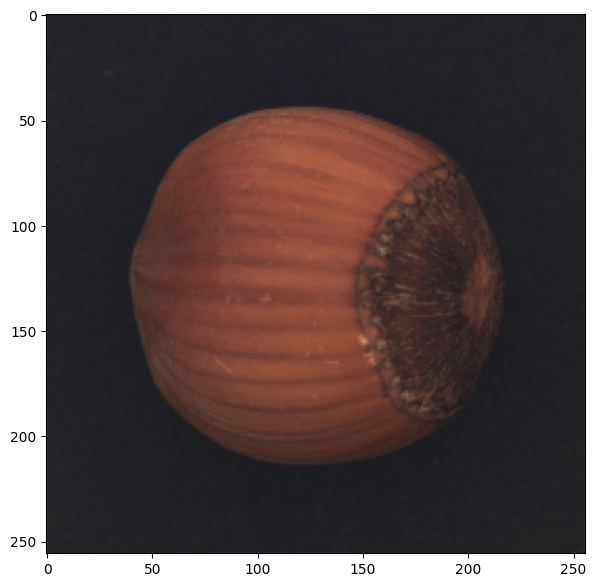

In [22]:
img = imgs[5]
img = img.permute(1,2,0).detach().cpu().numpy()
import matplotlib.pyplot as plt 
plt.figure(figsize=(7,7))
plt.imshow(img)
plt.show()